In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# pip install pgzip==0.3.0

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 239479174234407639
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3680501760
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16014516859388654401
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [4]:
import numpy as np

import sys
import time
sys.path.append("./Models")
import os
os.system('')

import subprocess
import torch
from torch.utils.data import Dataset

import pickle
import pgzip
import copy

import datetime

import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

In [5]:
#Default settings for experiment
arg_model = "tsrnn" #Options: 'trfbb', 'tsrnn', 'trfbf'
arg_dset = "dyt" #Datasets -- Spain: 'ree', AEP, DAYTON: 'dyt' London: 'lsm'

attr_dset_smpl_rt = 24 if arg_dset == "aep" else (48 if arg_dset == "lsm" else 24) #Samples per day. Spain, AEP: 24, London: 48
# param_dset_lookback_weeks = 5
# param_dset_forecast = 48 if arg_dset == "lsm" else 24
param_dset_lookback_weeks = 9
param_dset_forecast = 168 if arg_dset == "lsm" else 84 # 3.5days = 168
param_dset_train_stride = 48 #Choose a coprime value to the forecast so all reading frames are eventually considered
param_dset_test_stride = 'same' #tsrnn paper uses 1 week
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast

param_trf_weather = False



In [6]:
import pywt
from tqdm.auto import tqdm

# Get the maximum decomposition level
def print_maximal_decom_level(data):
    max_level = pywt.swt_max_level(data)
    print("Maximum decomposition level:", max_level)

    return max_level

# SWT functions
def data_preparation(dataset, window, lev):
    da = []
    max_level = print_maximal_decom_level(window)
    for i in tqdm(range(len(dataset)), total=len(dataset), desc="swt"):
        coeffs = pywt.swt(dataset[i], wavelet='db2', level=lev)
        da.append(coeffs);
    return da

def data_reconstruction(dataset):
    da = []
    for i in tqdm(range(len(dataset)), total= len(dataset), desc="iswt"):
#         recon = pywt.iswt(dataset[i,:,:,:].tolist(), 'db2')
        recon = pywt.iswt(dataset[i], 'db2')
#         print(np.array(recon).shape)
        da.append(recon)
#         da.append(recon[0][window-1])
    return da


# Called because iswt cannot accept tolist() dataset
def data_organization(coeffs):
    '''
    Reshape data back to (n,3,2,window_length), where there are 3 tuples of 2 values consisting of
    coeffs array_like Coefficients list of tuples:
    [(cAn, cDn), ..., (cA2, cD2), (cA1, cD1)]
    '''
    reshape_list = []
    for i in range(len(coeffs)):
        reshape_list.append([])
        for j in range(len(coeffs[0])):
            reshape_list[i].append(tuple(coeffs[i][j]))

    return reshape_list

In [7]:
# -*- coding: utf-8 -*-

import numpy as np

import os
import subprocess
import torch
from torch.utils.data import Dataset

import pickle
import pgzip
import copy

import datetime

class DAYTON(Dataset):
    """
    PJM-DAYTON dataset. Instantaneous power reported in MW.
    Ranges from around ??? GW (???? MW) to ??? GW (???? MW).
    """
    def __init__(self,path = '.',start_idx = 0, end_idx = 9999999,
                 seq_len = 816, pred_horz = 24, stride=-1, timestamp = True):
        assert(end_idx - start_idx > seq_len+pred_horz)
        if stride <= 0:
            stride = seq_len+pred_horz
        #if 'aep_tensor.pkl' not in os.listdir(path) or 'aep_timestamps.pkl' not in os.listdir(path):
        if 'dayton_dict.pkl.pgz' not in os.listdir(path):
            raise FileNotFoundError(os.listdir(path))
            #subprocess.check_call('python ./dayton_.py . aep_dict.pkl.pgz')

        # with open(os.path.join(path,'aep_tensor.pkl'),'rb') as f:
        #     series = pickle.load(f)
        # with open(os.path.join(path,'aep_timestamps.pkl'),'rb') as f:
        #     timestamps = pickle.load(f)

        with pgzip.open(os.path.join(path,'dayton_dict.pkl.pgz')) as f:
            sd = pickle.load(f)

        series = sd["tensor"] #121296 total elements
        starttime = sd['start_time']

        self.total_datapoints = len(series)

        end_idx = min(end_idx,len(series))

        wset = []
        ser_start = []
        pred_start = []
        i = start_idx
        while i + seq_len + pred_horz < end_idx:
            wset.append(series[i:i+seq_len+pred_horz])
            # ser_start.append(timestamps[i])
            # pred_start.append(timestamps[i+seq_len+1])
            ser_start.append(starttime + i*datetime.timedelta(hours=1))
            pred_start.append(starttime + (i + seq_len)*datetime.timedelta(hours=1))
            i += stride

        wset = torch.stack(wset).unsqueeze(-1)
        self.series = wset

        for i in range(len(ser_start)):
            tmptime = ser_start[i]
            ser_start[i] = [tmptime.year,
                            tmptime.month,
                            tmptime.day,
                            tmptime.hour,
                            tmptime.minute,
                            tmptime.second]

        for i in range(len(pred_start)):
            tmptime = pred_start[i]
            pred_start[i] = [tmptime.year,
                            tmptime.month,
                            tmptime.day,
                            tmptime.hour,
                            tmptime.minute,
                            tmptime.second]

        #Series normalization
        #Convert nans so that they do not count toward the min/max
        # smin = self.series.nan_to_num(nan=torch.finfo(self.series.dtype).max).amin(dim=-2,keepdim=True)
        # smax = self.series.nan_to_num(nan=torch.finfo(self.series.dtype).min).amax(dim=-2,keepdim=True)

        self._min = self.series[~self.series.isnan()].min()
        self._max = self.series[~self.series.isnan()].max()

        #self.series = (self.series - smin.broadcast_to(self.series.shape))/(smax-smin).broadcast_to(self.series.shape)
        self.series_starttimes = torch.tensor(ser_start,dtype=torch.long)
        self.pred_start = torch.tensor(pred_start,dtype=torch.long)

        self.length = len(self.series)
        self.return_timestamps = timestamp

        self.seq_len = seq_len
        self.pred_horz = pred_horz

        #Dataset in use will contain nans, to be handled by the training code

    def __len__(self):
        return self.length

    def min(self):
        """Returns the minimum load power in GW"""
        return self._min
        #return 18.041

    def max(self):
        """Returns the maximum load power in GW"""
        return self._max
        #return 41.015

    def __getitem__(self,idx):
        if self.return_timestamps:
            return self.series[idx][:self.seq_len], self.series[idx][self.seq_len:], self.series_starttimes[idx], self.pred_start[idx]
        return self.series[idx][:self.seq_len], self.series[idx][self.seq_len:]

In [8]:
# path = '/content/gdrive/MyDrive/FYP/Datasets/PJM_energy_datasets'
path = '.'
import sys
sys.path.insert(0,path)

full_set = DAYTON(path = ".",
                  seq_len = param_dset_lookback,
                  pred_horz = param_dset_forecast,
                  timestamp = False)
dytmax = full_set.max()
dytmin = full_set.min()
del(full_set)

train_set = DAYTON(path = ".",
                start_idx = 0, end_idx = 97036,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=29,
                timestamp = False)
val_set = DAYTON(path = ".",
              start_idx = 97036, end_idx = 97036+12129,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=param_dset_forecast,
                timestamp = False)
test_set = DAYTON(path = ".",
                start_idx = 97036+12129,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=param_dset_forecast,
                timestamp = False)


train_set.series = (train_set.series - dytmin)/(dytmax - dytmin)
val_set.series = (val_set.series - dytmin)/(dytmax - dytmin)
test_set.series = (test_set.series - dytmin)/(dytmax - dytmin)

print(train_set.series.shape)

torch.Size([3294, 1512, 1])


In [9]:
#SWT Transformation
def swt_transformation(self_series):
    self_series = self_series.squeeze(-1)
    print("total series shape after squeeze: ", self_series.shape)
    self_series_numpy = self_series.numpy()
    print("torch shape: ", self_series.shape)
    print("numpy shape: ", self_series_numpy.shape)
#     print(self_series[0])
#     print(self_series_numpy[0])
    lev = 2
    da = data_preparation(self_series_numpy, self_series_numpy.shape[1], lev)
#     print(da[0][0])

    Vv = np.array(da)
    print(Vv.shape)
    # print(Vv[0][0])

    vv = Vv.reshape(Vv.shape[0],2*lev*Vv.shape[3])
    print(vv.shape)


    # dataset = scaler.fit_transform(vv)

    dat = vv.reshape(Vv.shape[0],2*lev,Vv.shape[3])
    print(dat.shape)

    # Check Reconstruction whether it is correct -> This is correct
    # D = dat.reshape(Vv.shape[0],2*lev*Vv.shape[3])
    # print(D.shape)
    
    # R = D.reshape(Vv.shape[0],lev,2,Vv.shape[3])
    # print(R.shape)
    
    # R = data_organization(R)
    # # print(R[0][0])

    # re=data_reconstruction(R)
    # Re = np.array(re)
    # print(Re.shape)
    # print(self_series[0])
    # print(Re[0])

    return dat

train_set_transform = swt_transformation(train_set.series[:,:param_dset_lookback])
print("train_set_transform shape: ", train_set_transform.shape)
print("----------------------------------------------------")

val_set_transform = swt_transformation(val_set.series[:,:param_dset_lookback])
print("val_set_transform shape: ", val_set_transform.shape)
print("----------------------------------------------------")

test_set_transform = swt_transformation(test_set.series[:,:param_dset_lookback])
print("test_set_transform shape: ", test_set_transform.shape)
print("----------------------------------------------------")

total series shape after squeeze:  torch.Size([3294, 1428])
torch shape:  torch.Size([3294, 1428])
numpy shape:  (3294, 1428)
Maximum decomposition level: 2


swt:   0%|          | 0/3294 [00:00<?, ?it/s]

(3294, 2, 2, 1428)
(3294, 5712)
(3294, 4, 1428)
train_set_transform shape:  (3294, 4, 1428)
----------------------------------------------------
total series shape after squeeze:  torch.Size([127, 1428])
torch shape:  torch.Size([127, 1428])
numpy shape:  (127, 1428)
Maximum decomposition level: 2


swt:   0%|          | 0/127 [00:00<?, ?it/s]

(127, 2, 2, 1428)
(127, 5712)
(127, 4, 1428)
val_set_transform shape:  (127, 4, 1428)
----------------------------------------------------
total series shape after squeeze:  torch.Size([127, 1428])
torch shape:  torch.Size([127, 1428])
numpy shape:  (127, 1428)
Maximum decomposition level: 2


swt:   0%|          | 0/127 [00:00<?, ?it/s]

(127, 2, 2, 1428)
(127, 5712)
(127, 4, 1428)
test_set_transform shape:  (127, 4, 1428)
----------------------------------------------------


In [10]:
# Concat swt as features with original data as inputs
swt_train_features=torch.from_numpy(np.transpose(train_set_transform, (0, 2, 1)))
swt_val_features =torch.from_numpy(np.transpose(val_set_transform, (0, 2, 1)))
swt_test_features=torch.from_numpy(np.transpose(test_set_transform, (0, 2, 1)))

print(swt_train_features.shape)
print(swt_val_features.shape)
print(swt_test_features.shape)


torch.Size([3294, 1428, 4])
torch.Size([127, 1428, 4])
torch.Size([127, 1428, 4])


In [11]:
# Split seq_len and pred

trainX,trainY = train_set.series[:int(train_set_transform.shape[0]),:param_dset_lookback,:], train_set.series[:int(train_set_transform.shape[0]),param_dset_lookback:,:]
valX,valY = val_set.series[:,:param_dset_lookback,:], val_set.series[:,param_dset_lookback:,:]
testX,testY = test_set.series[:,:param_dset_lookback,:], test_set.series[:,param_dset_lookback:,:]

print(trainX.shape)
print(valX.shape)
print(testX.shape)

print(trainY.shape)
print(valY.shape)
print(testY.shape)

trainX = torch.cat((trainX, swt_train_features), dim=-1)
valX = torch.cat((valX, swt_val_features), dim=-1)
testX = torch.cat((testX, swt_test_features), dim=-1)

print(trainX.shape)
print(valX.shape)
print(testX.shape)





torch.Size([3294, 1428, 1])
torch.Size([127, 1428, 1])
torch.Size([127, 1428, 1])
torch.Size([3294, 84, 1])
torch.Size([127, 84, 1])
torch.Size([127, 84, 1])
torch.Size([3294, 1428, 5])
torch.Size([127, 1428, 5])
torch.Size([127, 1428, 5])


## Model Initialization

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# path1 = "/content/gdrive/MyDrive/FYP/Models"
# path2 = "/content/gdrive/MyDrive/FYP/Models/BigBirdSparse"
# import sys
# sys.path.insert(1,path1)
# sys.path.insert(2,path2)
import sys
sys.path.append("../../Models")

from Encodings.encoding import LearnablePositionalEncoding
from BigBirdSparse.bb_sparse import BlockSparseMultiheadAttention
from BigBirdSparse.bb_fixed import BlockSparseFixedAttention
from transformer_base import TBatchNorm

class TransformerBBSparse(nn.Module):
    def __init__(self, seq_len=2560, out_seq_len=24, interval=1, inp_dim=1, emb_dim=64,\
                 n_heads=4, n_enc_layers=2, n_dec_layers=2, block_size=40,\
                ffdim=128, drop_p = 0.1):
        super(TransformerBBSparse,self).__init__()
        self.seq_len = seq_len
        self.out_seq_len = out_seq_len
        self.emb_dim = emb_dim
        #self.in_norm = nn.BatchNorm1d(seq_len,affine=False)
        self.input_linear = nn.Linear(inp_dim,emb_dim)
        #self.input_pool = nn.AvgPool1d(kernel_size=5,stride=5)
        self.pe = LearnablePositionalEncoding(emb_dim,dropout=0.1,max_len=seq_len)
        #self.pe = CosineEmbedding(emb_dim,max_len=seq_len,scale_factor=0.1)
        #self.tpe = TimestampCosineEmbedding(emb_dim, interval, max_len = seq_len)

        self.trf_el = nn.TransformerEncoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)
        self.trf_el.self_attn = BlockSparseMultiheadAttention(emb_dim, n_heads, block_size,batch_first=True)
        #self.trf_el.self_attn = BlockSparseMheadAttnFixed(emb_dim, n_heads, block_size,batch_first=True)

        self.trf_dl = nn.TransformerDecoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)

        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm2 = TBatchNorm(num_features=emb_dim)

        self.trf_dl.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm2 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm3 = TBatchNorm(num_features=emb_dim)

        self.trf_e = nn.TransformerEncoder(self.trf_el,num_layers=n_enc_layers)
        self.trf_d = nn.TransformerDecoder(self.trf_dl,num_layers=n_dec_layers)

        # self.out = nn.Linear(emb_dim,inp_dim)
        self.out = nn.Linear(emb_dim,1)
        self.drop = nn.Dropout(p=drop_p)

        # self.dec_tar = torch.nn.Parameter(torch.zeros((out_seq_len,emb_dim)))
        # nn.init.normal_(self.dec_tar)
        self.aux_out = nn.Linear(emb_dim,1)#inp_dim)
        #self.reduce = nn.Linear(seq_len,out_seq_len)
        self.aux_in = nn.Linear(1,emb_dim)#inp_dim,emb_dim)

        self.expand = nn.Linear(seq_len,5120)
        self.compress = nn.Linear(5120,out_seq_len)

    def forward(self,x):
        '''x: [batch dim, sequence length, variable dim]'''
        x1 = self.input_linear(x) # x1.shape: [batch, seq len, emb dim]
        x1 = self.pe(x1.permute(1,0,2)).permute(1,0,2)
        #x1 = self.tpe(x1.permute(1,0,2),in_start_time).permute(1,0,2)
        mem = self.trf_e(x1)

        dec_in = self.aux_out(mem)
        dec_in = F.gelu(self.expand(dec_in.view((-1,self.seq_len))))
        dec_in = self.drop(dec_in)
        dec_in = self.compress(dec_in)
        #dec_in = F.gelu(self.reduce(dec_in.view((-1,self.seq_len))))

        dec_in = self.aux_in(dec_in.unsqueeze(-1))

        # x2 = self.trf_d(self.dec_tar.broadcast_to(x.shape[0],self.out_seq_len,self.emb_dim)\
        #                 ,mem)
        x2 = self.trf_d(self.pe(dec_in.permute(1,0,2))\
                        .permute(1,0,2),mem)
        # x2 = self.trf_d(self.tpe(dec_in.permute(1,0,2),pred_start_time)\
        #                 .permute(1,0,2),mem)

        o1 = self.out(x2)

        return o1



In [13]:
class TransformerBBFixed(nn.Module):
    def __init__(self, seq_len=2560, out_seq_len=24, interval=1, inp_dim=1, emb_dim=64,\
                 n_heads=4, n_enc_layers=2, n_dec_layers=2, block_size=40,\
                ffdim=128, drop_p = 0.1):
        super(TransformerBBFixed,self).__init__()
        self.seq_len = seq_len
        self.out_seq_len = out_seq_len
        self.emb_dim = emb_dim
        #self.in_norm = nn.BatchNorm1d(seq_len,affine=False)
        self.input_linear = nn.Linear(inp_dim,emb_dim)
        #self.input_pool = nn.AvgPool1d(kernel_size=5,stride=5)
        self.pe = LearnablePositionalEncoding(emb_dim,dropout=drop_p,max_len=seq_len)
        #self.pe = CosineEmbedding(emb_dim,max_len=seq_len,scale_factor=0.1)
        #self.tpe = TimestampCosineEmbedding(emb_dim, interval, max_len = seq_len)

        self.trf_el = nn.TransformerEncoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)
        #self.trf_el.self_attn = BlockSparseMultiheadAttention(emb_dim, n_heads, block_size,batch_first=True)
        self.trf_el.self_attn = BlockSparseFixedAttention(emb_dim, n_heads, block_size,batch_first=True)

        self.trf_dl = nn.TransformerDecoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)

        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm2 = TBatchNorm(num_features=emb_dim)

        self.trf_dl.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm2 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm3 = TBatchNorm(num_features=emb_dim)

        self.trf_e = nn.TransformerEncoder(self.trf_el,num_layers=n_enc_layers)
        self.trf_d = nn.TransformerDecoder(self.trf_dl,num_layers=n_dec_layers)

        # self.out = nn.Linear(emb_dim,inp_dim)
        self.out = nn.Linear(emb_dim,1)
        self.drop = nn.Dropout(p=drop_p)

        # self.dec_tar = torch.nn.Parameter(torch.zeros((out_seq_len,emb_dim)))
        # nn.init.normal_(self.dec_tar)
        self.aux_out = nn.Linear(emb_dim,1)#inp_dim)
        #self.reduce = nn.Linear(seq_len,out_seq_len)
        self.aux_in = nn.Linear(1,emb_dim)#inp_dim,emb_dim)

        self.expand = nn.Linear(seq_len,5120)
        self.compress = nn.Linear(5120,out_seq_len)

    def forward(self,x):
        '''x: [batch dim, sequence length, variable dim]'''
        x1 = self.input_linear(x) # x1.shape: [batch, seq len, emb dim]
        x1 = self.pe(x1.permute(1,0,2)).permute(1,0,2)
        #x1 = self.tpe(x1.permute(1,0,2),in_start_time).permute(1,0,2)
        mem = self.trf_e(x1)

        dec_in = self.aux_out(mem)
        dec_in = F.gelu(self.expand(dec_in.view((-1,self.seq_len))))
        dec_in = self.drop(dec_in)
        dec_in = self.compress(dec_in)
        #dec_in = F.gelu(self.reduce(dec_in.view((-1,self.seq_len))))

        dec_in = self.aux_in(dec_in.unsqueeze(-1))

        # x2 = self.trf_d(self.dec_tar.broadcast_to(x.shape[0],self.out_seq_len,self.emb_dim)\
        #                 ,mem)
        x2 = self.trf_d(self.pe(dec_in.permute(1,0,2))\
                        .permute(1,0,2),mem)
        # x2 = self.trf_d(self.tpe(dec_in.permute(1,0,2),pred_start_time)\
        #                 .permute(1,0,2),mem)

        o1 = self.out(x2)

        return o1

In [14]:
# Early stopping
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

class SaveBestModel:
    """
    Class to save or load the best model while training.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss, epoch, model
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
#             print(f"\nBest validation loss: {self.best_valid_loss}")
#             print(f"\nSaving best model for epoch: {epoch+1}\n")
            # Save the PyTorch model
            torch.save(model.state_dict(), 'transformer_5min.pth')

patience = 50
early_stopper = EarlyStopper(patience=patience, min_delta=0)
saveBestModel = SaveBestModel()

## Create model and data tensor

In [15]:
batch_size = 64
lev=2

seq_len = param_dset_lookback
print(seq_len)

# Transformer parameters
inp_len = 2*lev + 1
# inp_len = 1
out_len = 2*lev
emb_dim = 3 * inp_len # Must be 3 * inp_len
n_heads = 3 # divisible by emb_dim
enc_layer = 4
dec_layer = 4
ff_dim = 256
param_trf_bksz = 84

1428


In [16]:
# model = create_model()
# model.summary()

# # Training data
# X_train, y_train = trainX,trainY
# ###############################################################################
# # Validation data
# X_val, y_val = testX,testY
# ###############################################################################
# # Test data
# X_test, y_test = testX_a,testY_a
# callback = tf.keras.callbacks.ModelCheckpoint('Transformer_5min.hdf5',
#                                                       monitor='val_loss',
#                                                       save_best_only=True,
#                                                       verbose=1)
# with tf.device("/gpu:0"):
#     history = model.fit(X_train, y_train,
#                             batch_size=batch_size,
# #                             epochs=50,
#                             epochs=1,
#                             validation_data=(X_val, y_val),
#                             callbacks=[callback])

# model = tf.keras.models.load_model('Transformer_5min.hdf5',
#                                            custom_objects={'Time2Vector': Time2Vector,
#                                                            'SingleAttention': SingleAttention,
#                                                            'MultiAttention': MultiAttention,
#                                                            'TransformerEncoder': TransformerEncoder,
#                                                            'TransformerDecoder': TransformerDecoder}
#                                            )

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

torch.manual_seed(42)

# Create PyTorch model
model = TransformerBBFixed(seq_len = param_dset_lookback,
                          # out_seq_len = param_dset_forecast,
                          out_seq_len = param_dset_forecast,
                          inp_dim = inp_len,
                          emb_dim = emb_dim,
                          n_heads = n_heads,
                          n_enc_layers = enc_layer,
                          n_dec_layers = dec_layer,
                          block_size=param_trf_bksz,
                          ffdim = ff_dim)

# Print model summary
# print(model)
def num_parameters(m):
    return sum([p.numel() for p in m.parameters()])

parameters = num_parameters(model)

# print(f"Expected number of parameters: {m * dk * dk + m * 1 * 1 * n}")
print(f"Actual number of model parameters: {parameters}")

trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable model parameters: {trainable_params}" )

# total_params = 0
# for name, parameter in model.named_parameters():
#     if not parameter.requires_grad:
#         continue
#     params = parameter.numel()
#     print(f"{name}, {params}")
#     total_params+=params
# print(f"Total Trainable Params: {total_params}")


# Convert data to PyTorch tensors
# X_train, y_train = torch.tensor(trainX), torch.tensor(trainY)
# X_val, y_val = torch.tensor(valX), torch.tensor(valY)
# X_test, y_test = torch.tensor(testX), torch.tensor(testY)

X_train, y_train = trainX.clone(), trainY.clone()
X_val, y_val = valX.clone(), valY.clone()
X_test, y_test = testX.clone(), testY.clone()

# Create DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.001, eps=1e-07)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

# Training loop
num_epochs = 1000  # Replace with your desired number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

for epoch in tqdm(range(num_epochs), total= num_epochs, desc="epochs", position=0, leave=True):
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_loader, total=len(train_loader), desc="train batches", position=1, leave=True):
        inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        # print("inputs: ", inputs.shape)
        # print("targets: ", targets.shape)
        # print("outputs: ", outputs.shape)
        loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])

#         loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

#         for p in model.parameters():
#             print(p.grad.norm())

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, total=len(val_loader), desc="val batches", position=2, leave=True):
            inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')

    saveBestModel(val_loss, epoch, model)

    # Early stopping with patience
    if early_stopper.early_stop(val_loss):
        print("Done!")
        break


Actual number of model parameters: 7860476
Trainable model parameters: 7860476
cuda


epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/1000, Training Loss: 102.242118, Validation Loss: 0.447890


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/1000, Training Loss: 0.061150, Validation Loss: 0.051971


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/1000, Training Loss: 0.043623, Validation Loss: 0.035777


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/1000, Training Loss: 0.036392, Validation Loss: 0.026651


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/1000, Training Loss: 0.032678, Validation Loss: 0.026283


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/1000, Training Loss: 0.030695, Validation Loss: 0.024324


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/1000, Training Loss: 0.037099, Validation Loss: 0.024244


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/1000, Training Loss: 0.095172, Validation Loss: 0.098758


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/1000, Training Loss: 0.044757, Validation Loss: 0.024814


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/1000, Training Loss: 0.047889, Validation Loss: 0.034875


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/1000, Training Loss: 0.061925, Validation Loss: 0.021064


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/1000, Training Loss: 0.047304, Validation Loss: 0.021909


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/1000, Training Loss: 0.045552, Validation Loss: 0.020211


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/1000, Training Loss: 0.059177, Validation Loss: 0.021371


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/1000, Training Loss: 0.056478, Validation Loss: 0.022447


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/1000, Training Loss: 0.046283, Validation Loss: 0.019932


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/1000, Training Loss: 0.033224, Validation Loss: 0.018685


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/1000, Training Loss: 0.047254, Validation Loss: 0.018182


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/1000, Training Loss: 0.030759, Validation Loss: 0.017811


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/1000, Training Loss: 15.397239, Validation Loss: 0.028360


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/1000, Training Loss: 0.040619, Validation Loss: 0.021147


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/1000, Training Loss: 0.031936, Validation Loss: 0.019666


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/1000, Training Loss: 0.029549, Validation Loss: 0.019460


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/1000, Training Loss: 0.027950, Validation Loss: 0.019517


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/1000, Training Loss: 0.028690, Validation Loss: 0.019650


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26/1000, Training Loss: 0.031141, Validation Loss: 0.020320


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27/1000, Training Loss: 0.030633, Validation Loss: 0.021036


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28/1000, Training Loss: 0.033572, Validation Loss: 0.020657


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29/1000, Training Loss: 0.034090, Validation Loss: 0.020044


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/1000, Training Loss: 0.027616, Validation Loss: 0.019531


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31/1000, Training Loss: 0.038080, Validation Loss: 0.023045


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32/1000, Training Loss: 0.037985, Validation Loss: 0.019968


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33/1000, Training Loss: 0.024664, Validation Loss: 0.018526


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34/1000, Training Loss: 0.041589, Validation Loss: 0.017966


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/1000, Training Loss: 0.032571, Validation Loss: 0.018677


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36/1000, Training Loss: 1.463137, Validation Loss: 0.029894


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37/1000, Training Loss: 0.027638, Validation Loss: 0.018935


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38/1000, Training Loss: 0.026965, Validation Loss: 0.018819


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39/1000, Training Loss: 0.025458, Validation Loss: 0.018789


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/1000, Training Loss: 0.030470, Validation Loss: 0.018805


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41/1000, Training Loss: 0.028019, Validation Loss: 0.018980


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42/1000, Training Loss: 0.033431, Validation Loss: 0.019180


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43/1000, Training Loss: 0.032290, Validation Loss: 0.019521


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44/1000, Training Loss: 0.025744, Validation Loss: 0.019047


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45/1000, Training Loss: 0.030368, Validation Loss: 0.019579


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46/1000, Training Loss: 0.028099, Validation Loss: 0.018614


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47/1000, Training Loss: 0.031456, Validation Loss: 0.018789


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48/1000, Training Loss: 0.025835, Validation Loss: 0.017977


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49/1000, Training Loss: 0.026314, Validation Loss: 0.018548


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/1000, Training Loss: 0.027376, Validation Loss: 0.018173


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51/1000, Training Loss: 0.035802, Validation Loss: 0.019861


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52/1000, Training Loss: 0.023267, Validation Loss: 0.017366


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53/1000, Training Loss: 0.022395, Validation Loss: 0.017658


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54/1000, Training Loss: 0.967700, Validation Loss: 0.024911


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55/1000, Training Loss: 0.023377, Validation Loss: 0.020393


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56/1000, Training Loss: 0.022465, Validation Loss: 0.019984


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57/1000, Training Loss: 0.021944, Validation Loss: 0.020004


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58/1000, Training Loss: 0.022670, Validation Loss: 0.019652


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59/1000, Training Loss: 0.025374, Validation Loss: 0.020165


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60/1000, Training Loss: 0.022907, Validation Loss: 0.019269


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61/1000, Training Loss: 0.022155, Validation Loss: 0.019099


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62/1000, Training Loss: 0.024408, Validation Loss: 0.019289


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63/1000, Training Loss: 0.024052, Validation Loss: 0.019799


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64/1000, Training Loss: 0.024579, Validation Loss: 0.019327


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65/1000, Training Loss: 0.022984, Validation Loss: 0.021670


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66/1000, Training Loss: 0.025675, Validation Loss: 0.018905


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67/1000, Training Loss: 0.023602, Validation Loss: 0.019042


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68/1000, Training Loss: 0.024893, Validation Loss: 0.018827


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69/1000, Training Loss: 0.021411, Validation Loss: 0.019581


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70/1000, Training Loss: 0.026604, Validation Loss: 0.018249


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 71/1000, Training Loss: 0.020448, Validation Loss: 0.019325


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 72/1000, Training Loss: 0.032397, Validation Loss: 0.021647


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 73/1000, Training Loss: 0.021978, Validation Loss: 0.017619


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 74/1000, Training Loss: 0.019499, Validation Loss: 0.016539


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 75/1000, Training Loss: 0.020586, Validation Loss: 0.016594


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 76/1000, Training Loss: 0.019282, Validation Loss: 0.016449


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 77/1000, Training Loss: 0.022126, Validation Loss: 0.015420


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 78/1000, Training Loss: 0.017296, Validation Loss: 0.014440


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 79/1000, Training Loss: 0.016628, Validation Loss: 0.009527


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 80/1000, Training Loss: 0.011374, Validation Loss: 0.007376


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 81/1000, Training Loss: 0.010704, Validation Loss: 0.007170


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 82/1000, Training Loss: 0.009662, Validation Loss: 0.006551


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 83/1000, Training Loss: 0.010320, Validation Loss: 0.007324


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 84/1000, Training Loss: 0.008661, Validation Loss: 0.006428


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 85/1000, Training Loss: 0.008901, Validation Loss: 0.008210


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 86/1000, Training Loss: 0.007963, Validation Loss: 0.006996


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 87/1000, Training Loss: 0.007570, Validation Loss: 0.007882


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 88/1000, Training Loss: 0.009065, Validation Loss: 0.007728


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 89/1000, Training Loss: 0.031364, Validation Loss: 0.021148


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 90/1000, Training Loss: 0.033731, Validation Loss: 0.017232


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 91/1000, Training Loss: 0.012743, Validation Loss: 0.009292


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 92/1000, Training Loss: 0.008856, Validation Loss: 0.007277


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 93/1000, Training Loss: 0.008064, Validation Loss: 0.007854


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 94/1000, Training Loss: 0.007793, Validation Loss: 0.008041


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 95/1000, Training Loss: 0.007301, Validation Loss: 0.007036


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 96/1000, Training Loss: 0.007935, Validation Loss: 0.007492


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 97/1000, Training Loss: 0.007202, Validation Loss: 0.007569


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 98/1000, Training Loss: 0.007776, Validation Loss: 0.008068


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 99/1000, Training Loss: 0.006966, Validation Loss: 0.007519


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 100/1000, Training Loss: 0.006875, Validation Loss: 0.007510


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 101/1000, Training Loss: 0.007097, Validation Loss: 0.008036


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 102/1000, Training Loss: 0.006766, Validation Loss: 0.007398


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 103/1000, Training Loss: 0.007133, Validation Loss: 0.008322


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 104/1000, Training Loss: 0.006562, Validation Loss: 0.007413


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 105/1000, Training Loss: 0.006178, Validation Loss: 0.008184


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 106/1000, Training Loss: 0.006413, Validation Loss: 0.006806


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 107/1000, Training Loss: 0.006354, Validation Loss: 0.006806


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 108/1000, Training Loss: 0.005790, Validation Loss: 0.007412


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 109/1000, Training Loss: 0.007989, Validation Loss: 0.007333


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 110/1000, Training Loss: 0.005121, Validation Loss: 0.007116


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 111/1000, Training Loss: 0.005103, Validation Loss: 0.008177


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 112/1000, Training Loss: 0.006008, Validation Loss: 0.007127


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 113/1000, Training Loss: 0.007741, Validation Loss: 0.007132


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 114/1000, Training Loss: 0.004777, Validation Loss: 0.006290


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 115/1000, Training Loss: 0.004781, Validation Loss: 0.007006


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 116/1000, Training Loss: 0.004882, Validation Loss: 0.007157


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 117/1000, Training Loss: 0.004494, Validation Loss: 0.006932


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 118/1000, Training Loss: 0.004976, Validation Loss: 0.006232


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 119/1000, Training Loss: 0.005431, Validation Loss: 0.006844


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 120/1000, Training Loss: 0.004548, Validation Loss: 0.007151


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 121/1000, Training Loss: 0.004318, Validation Loss: 0.005766


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 122/1000, Training Loss: 0.005022, Validation Loss: 0.007952


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 123/1000, Training Loss: 0.004016, Validation Loss: 0.006217


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 124/1000, Training Loss: 0.004171, Validation Loss: 0.008428


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 125/1000, Training Loss: 0.004719, Validation Loss: 0.005723


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 126/1000, Training Loss: 0.004094, Validation Loss: 0.006346


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 127/1000, Training Loss: 0.004063, Validation Loss: 0.006940


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 128/1000, Training Loss: 0.004562, Validation Loss: 0.005779


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 129/1000, Training Loss: 0.003504, Validation Loss: 0.006254


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 130/1000, Training Loss: 0.004025, Validation Loss: 0.007662


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 131/1000, Training Loss: 0.003952, Validation Loss: 0.005990


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 132/1000, Training Loss: 0.004513, Validation Loss: 0.006904


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 133/1000, Training Loss: 0.003216, Validation Loss: 0.006926


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 134/1000, Training Loss: 0.003244, Validation Loss: 0.006573


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 135/1000, Training Loss: 0.004156, Validation Loss: 0.008294


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 136/1000, Training Loss: 0.003333, Validation Loss: 0.006580


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 137/1000, Training Loss: 0.003595, Validation Loss: 0.006508


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 138/1000, Training Loss: 0.003177, Validation Loss: 0.006185


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 139/1000, Training Loss: 0.003139, Validation Loss: 0.007794


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 140/1000, Training Loss: 0.003157, Validation Loss: 0.006421


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 141/1000, Training Loss: 0.003346, Validation Loss: 0.006269


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 142/1000, Training Loss: 0.003200, Validation Loss: 0.006281


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 143/1000, Training Loss: 0.003315, Validation Loss: 0.006641


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 144/1000, Training Loss: 0.003033, Validation Loss: 0.006515


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 145/1000, Training Loss: 0.002748, Validation Loss: 0.007770


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 146/1000, Training Loss: 0.003352, Validation Loss: 0.006143


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 147/1000, Training Loss: 0.002959, Validation Loss: 0.007394


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 148/1000, Training Loss: 0.002547, Validation Loss: 0.007313


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 149/1000, Training Loss: 0.002818, Validation Loss: 0.006523


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 150/1000, Training Loss: 0.002750, Validation Loss: 0.008515


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 151/1000, Training Loss: 0.003411, Validation Loss: 0.006126


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 152/1000, Training Loss: 0.002310, Validation Loss: 0.006554


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 153/1000, Training Loss: 0.002389, Validation Loss: 0.007123


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 154/1000, Training Loss: 0.002840, Validation Loss: 0.005848


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 155/1000, Training Loss: 0.002596, Validation Loss: 0.006460


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 156/1000, Training Loss: 0.002273, Validation Loss: 0.007608


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 157/1000, Training Loss: 0.002271, Validation Loss: 0.006262


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 158/1000, Training Loss: 0.003528, Validation Loss: 0.006621


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 159/1000, Training Loss: 0.002196, Validation Loss: 0.006493


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 160/1000, Training Loss: 0.002182, Validation Loss: 0.007004


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 161/1000, Training Loss: 0.002112, Validation Loss: 0.006782


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 162/1000, Training Loss: 0.002727, Validation Loss: 0.007371


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 163/1000, Training Loss: 0.002371, Validation Loss: 0.007058


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 164/1000, Training Loss: 0.002262, Validation Loss: 0.006497


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 165/1000, Training Loss: 0.001870, Validation Loss: 0.006946


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 166/1000, Training Loss: 0.002474, Validation Loss: 0.007416


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 167/1000, Training Loss: 0.002186, Validation Loss: 0.006671


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 168/1000, Training Loss: 0.001851, Validation Loss: 0.007148


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 169/1000, Training Loss: 0.002333, Validation Loss: 0.006198


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 170/1000, Training Loss: 0.002023, Validation Loss: 0.007248


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 171/1000, Training Loss: 0.001814, Validation Loss: 0.007107


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 172/1000, Training Loss: 0.002320, Validation Loss: 0.007722


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 173/1000, Training Loss: 0.001880, Validation Loss: 0.007130


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 174/1000, Training Loss: 0.002451, Validation Loss: 0.006851


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 175/1000, Training Loss: 0.001878, Validation Loss: 0.007924
Done!


In [17]:
# Load the PyTorch model
loaded_model = TransformerBBFixed(seq_len = param_dset_lookback,
                          # out_seq_len = param_dset_forecast,
                          out_seq_len = param_dset_forecast,
                          inp_dim = inp_len,
                          emb_dim = emb_dim,
                          n_heads = n_heads,
                          n_enc_layers = enc_layer,
                          n_dec_layers = dec_layer,
                          block_size=param_trf_bksz,
                          ffdim = ff_dim)

loaded_model.load_state_dict(torch.load('transformer_5min.pth'))
loaded_model.to(device)
loaded_model.eval()

# Use the whole signal (both train and validation data)
# The metrics are computed only using the validation part.
# This is needed for the signal processing
print(testX.shape)

# Testing the model on the test dataset
test_outputs = []
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, total=len(test_loader), desc="test batch"):
        inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
        outputs = loaded_model(inputs)
        test_outputs.append(outputs.cpu().numpy())  # Collect the outputs

        loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
        test_loss += loss
#         test_loss += criterion(outputs, targets).item()

testPredict_a = np.concatenate(test_outputs, axis=0)  # Concatenate outputs into a single numpy array
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# # Result from test
# testPredict_a = np.transpose(testPredict_a, (0, 2, 1))
# print(testPredict_a.shape)

# testX_original = np.transpose(testX, (0, 2, 1))
# print(testX_original.shape)

# test_cat = np.concatenate((testX_original, testPredict_a), axis=2)
# print(test_cat.shape)

torch.Size([127, 1428, 5])


test batch:   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 0.0063


In [18]:

# D = test_cat.reshape(test_cat.shape[0],test_cat.shape[1]*test_cat.shape[2])
# print(D.shape)

# R = D.reshape(test_cat.shape[0],lev,2,test_cat.shape[2])
# print(R.shape)

# R = data_organization(R)

# # print(R)

# re=data_reconstruction(R)
# Re = np.array(re)
# print(Re.shape)


# # Re = np.nan_to_num(Re)
# Re = torch.from_numpy(Re)

In [19]:
Re = testPredict_a.squeeze(-1)
Re = torch.from_numpy(Re)
print(Re.shape)

test_set_squeeze = test_set.series.squeeze(-1)
print("test truth: ", test_set_squeeze.shape)

test_rmse = torch.nn.MSELoss(reduction='none')(test_set_squeeze[:,param_dset_lookback:], Re[:,:]).nanmean().sqrt_()
print(test_rmse)

torch.Size([127, 84])
test truth:  torch.Size([127, 1512])
tensor(0.0795)


In [20]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt


# test_set_squeeze = test_set.series.squeeze(-1)
# print("test truth: ", test_set_squeeze.shape)

# print(test_set_squeeze[:,param_dset_lookback:].shape)
# print(Re[:,param_dset_lookback:].shape)


# test_rmse = math.sqrt( mean_squared_error(test_set_squeeze[:,param_dset_lookback:], Re[:,param_dset_lookback:]))
# # test_rmse = math.sqrt( mean_squared_error(test_compare, Re))

# test_mae=mean_absolute_error(test_set_squeeze[:,param_dset_lookback:], Re[:,param_dset_lookback:])
# # test_mae=mean_absolute_error(test_compare, Re)

# # mape=100*np.mean(np.divide(abs(test_compare[:,1632:]- Re[:,1632:]),test_compare[:,1632:]))

test_actual = test_set_squeeze[:,param_dset_lookback:]
test_predict = Re[:,:]

test_rmse = torch.nn.MSELoss(reduction='none')(test_actual, test_predict).nanmean().sqrt_()

test_mae = (test_predict-test_actual).abs_().nanmean()

mape = (2*(test_actual-test_predict).abs_() / (test_actual.abs() + test_predict.abs())).nanmean()

In [21]:
print('RMSE:  %.6f' % test_rmse)
print('MAE:  %.6f' % test_mae)
print('MAPE:  %.6f' % mape)

RMSE:  0.079468
MAE:  0.061283
MAPE:  0.169047


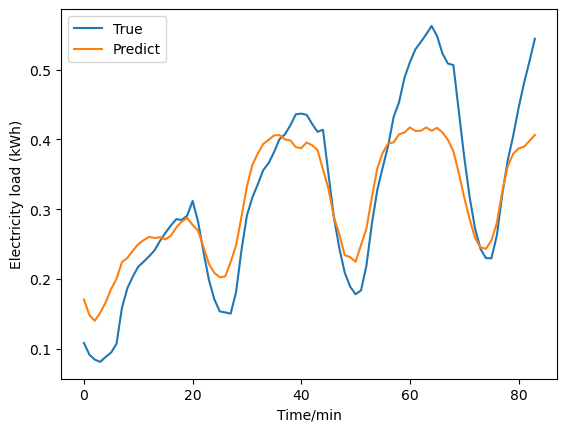

In [22]:
fig = plt.figure()
# print(test_set_squeeze[:3,param_dset_lookback:])
# print(Re[:3,param_dset_lookback:])
plt.plot(test_set_squeeze[:1,param_dset_lookback:][0])
plt.plot(Re[:1,:][0])
plt.xlabel('Time/min')
plt.ylabel('Electricity load (kWh)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()


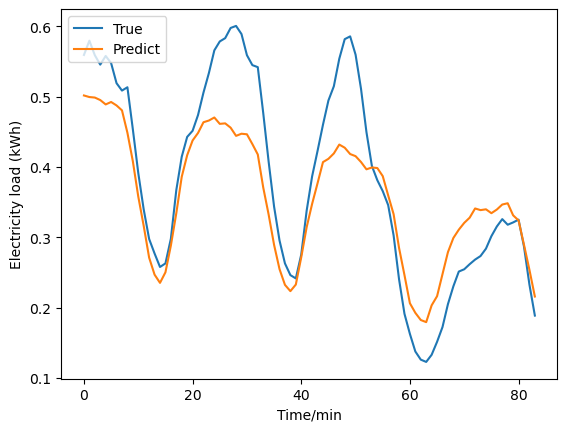

In [23]:
fig = plt.figure()
# print(test_set_squeeze[:3,param_dset_lookback:])
# print(Re[:3,param_dset_lookback:])
plt.plot(test_set_squeeze[1:2,param_dset_lookback:][0])
plt.plot(Re[1:2,:][0])
plt.xlabel('Time/min')
plt.ylabel('Electricity load (kWh)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()

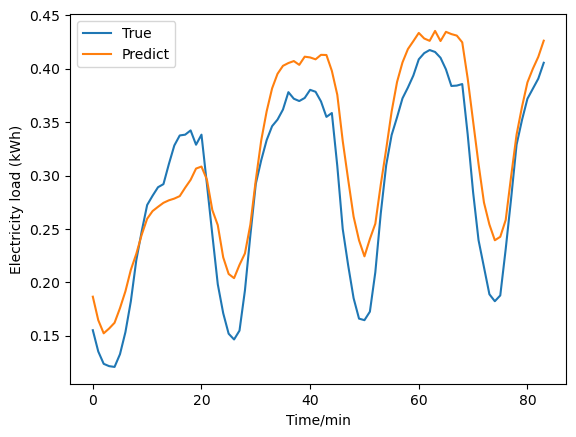

In [24]:
fig = plt.figure()
# print(test_set_squeeze[:3,param_dset_lookback:])
# print(Re[:3,param_dset_lookback:])
plt.plot(test_set_squeeze[2:3,param_dset_lookback:][0])
plt.plot(Re[2:3,:][0])
plt.xlabel('Time/min')
plt.ylabel('Electricity load (kWh)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()